# Proposed CNN Model for Road Sound Datasets - Log-Mel Spectrograms



#### * Load required libraries

In [1]:
import sys
import os
import IPython
import math
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

import random
from datetime import datetime
from include import helpers

from keras import backend as keras_backend
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten, LeakyReLU, ReLU, SpatialDropout2D, Activation, Conv2D 
from keras.layers import MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.utils import np_utils, to_categorical, plot_model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.regularizers import l2

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_recall_fscore_support, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score  

Using TensorFlow backend.


#### * Setup

In [2]:
# Set your path to the original dataset
us8k_path = os.path.abspath('../Yi-Source-Code-3/input/vds_sound')
metadata_path = os.path.join(us8k_path, 'metadata/sound_vds15_vds16_14k.csv')
audio_path = os.path.join(us8k_path, 'audio')


In [3]:
models_path = os.path.abspath('./models')
data_path = os.path.abspath('./data')
results_path = os.path.abspath('./results')

# Ensure "channel last" data format on Keras
keras_backend.set_image_data_format('channels_last')

In [4]:
# Required for the RTX GPU -- uncomment if using GTX or CPU
import keras.backend as K
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
K.set_session(tf.Session(config=config))

In [5]:
# Define a labels array for future use
#labels = ['9 am', '13 pm', '19 pm']
#labels = ['morning', 'afternoon','evening']
#labels = ['down_1', 'down_2','down_3', 'up_4','up_5','up_6']
labels = ['1', '2','3', '4','5','6']


num_epochs = 200
num_batch_size = 64
file_name = 'conv5_gap_train_C6_MFCC_40'
model_path = os.path.join(models_path, file_name + '.hdf5')

#### * Load data

Data is an NumPy float32 array of shape (8732, 40, 174), 8732 samples with coefficients from Mel Spectrogram of 174 frames and 40 MEL bands. Each feature was scaled between -1 and 1 and zero-centered during extraction.<br/>
<br/>

In [6]:
# Pre-processed MFCC coefficients
X = np.load("./data/X_C6_mfcc_40_14k.npy")
y = np.load("./data/y_C6_mfcc_40_14k.npy")

print(X.shape, y.shape)
# Metadata
metadata = pd.read_csv(metadata_path)

(14255, 40, 173) (14255,)


### 1. Data preparation: features + metadata

#### 1.1 Train / Test split
Note that we are using the same index order for both the Mel Spectrogram arrays and the metadata to keep track of the origin of each feature.<br/>
<br/>

In [7]:
indexes = []
total = len(metadata)
indexes = list(range(0, total))

# Randomize indexes
random.shuffle(indexes)

# Divide the indexes into Train and Test
test_split_pct = 20
split_offset = math.floor(test_split_pct * total / 100)

# Split the metadata
test_split_idx = indexes[0:split_offset]
train_split_idx = indexes[split_offset:total]


# Split the features with the same indexes
X_test = np.take(X, test_split_idx, axis=0)
y_test = np.take(y, test_split_idx, axis=0)
X_train = np.take(X, train_split_idx, axis=0)
y_train = np.take(y, train_split_idx, axis=0)

# Also split metadata
test_meta = metadata.iloc[test_split_idx]
train_meta = metadata.iloc[train_split_idx]

# Print status
print("Test split: {} \t\t Train split: {}".format(len(test_meta), len(train_meta)))
print("X test shape: {} \t X train shape: {}".format(X_test.shape, X_train.shape))
print("y test shape: {} \t\t y train shape: {}".format(y_test.shape, y_train.shape))

Test split: 2851 		 Train split: 11404
X test shape: (2851, 40, 173) 	 X train shape: (11404, 40, 173)
y test shape: (2851,) 		 y train shape: (11404,)


#### 1.2 One hot encode labels

In [8]:
le = LabelEncoder()
y_test_encoded = to_categorical(le.fit_transform(y_test))
y_train_encoded = to_categorical(le.fit_transform(y_train))

#### 1.3 Reshape data

In [9]:
# How data should be structured
num_rows = 40
num_columns = 173 
num_channels = 1

# Reshape to fit the network input (channel last)
X_train = X_train.reshape(X_train.shape[0], num_rows, num_columns, num_channels)
X_test = X_test.reshape(X_test.shape[0], num_rows, num_columns, num_channels)

# Total number of labels to predict (equal to the network output nodes)
num_labels = y_train_encoded.shape[1]
print('number of labels=',num_labels)

number of labels= 6


## 2. Proposed CNN network



#### 2.1 Model definition



In [10]:
def create_model(): 

    model = Sequential()
    #conv 1 (40x173)
    model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same',
    input_shape=(num_rows, num_columns, num_channels)))    
    model.add(ReLU())    
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.4)) 

    
    #conv 2 (20x86)
    model.add(Conv2D(filters=64, kernel_size=(3, 3),  padding='same')) 
    model.add(ReLU())   
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.4)) 
 

    #conv 3 (10x43)
    model.add(Conv2D(filters=128, kernel_size=(3, 3),  padding='same')) 
    model.add(ReLU())   
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.4)) 

 
    #conv 4 (5x21)
    model.add(Conv2D(filters=256, kernel_size=(3,3),  padding='same'))  
    model.add(ReLU())   
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.4)) 
 
    #conv 5 (2x10)
    model.add(Conv2D(filters=512, kernel_size=(3,3),  padding='same'))  
    model.add(ReLU()) 
    model.add(Dropout(0.4)) 
    
    #conv 6 (1x5)
    #model.add(MaxPooling2D(pool_size=(2, 2)))
    #model.add(Flatten())
    model.add(GlobalAveragePooling2D())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5)) 
    model.add(Dense(num_labels, activation='softmax'))
    
    return model

model = create_model() 


Instructions for updating:
If using Keras pass *_constraint arguments to layers.



In [11]:
adam = Adam(lr=2e-4, beta_1=0.9, beta_2=0.999,epsilon=1e-08, decay=0.0)
model.compile(
    loss='categorical_crossentropy', 
    metrics=['accuracy'], 
    optimizer=adam)

# Display model architecture summary 
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 40, 173, 32)       320       
_________________________________________________________________
re_lu_1 (ReLU)               (None, 40, 173, 32)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 20, 86, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 20, 86, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 86, 64)        18496     
_________________________________________________________________
re_lu_2 (ReLU)               (None, 20, 86, 64)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 10, 43, 64)       

In [12]:

# Save checkpoints

early_stopping = EarlyStopping(patience = 30) 
checkpointer = ModelCheckpoint(filepath=model_path, 
                               verbose=1, save_best_only=True)
callback_reduce_lr=ReduceLROnPlateau(monitor='val_loss',
                                     factor=0.1,
                                     min_lr=1e-6,
                                     patience=10,
                                     verbose=1)
start = datetime.now()
history = model.fit(X_train, 
                    y_train_encoded, 
                    batch_size=num_batch_size, 
                    epochs=num_epochs, 
                    validation_split=0.1,
                    callbacks=[early_stopping, callback_reduce_lr, checkpointer], 
                    verbose=1)
duration = datetime.now() - start
print("Training completed in time: ", duration)
file1 = open(os.path.join(models_path, 'time_' + file_name + ".txt"),"w")
file1.write('Training Time:' + str(duration))
file1.write('\n')
file1.close()





Train on 10263 samples, validate on 1141 samples
Epoch 1/200
10263/10263 [==============================] - 6s 546us/step - loss: 1.7752 - accuracy: 0.1915 - val_loss: 1.7506 - val_accuracy: 0.2375

Epoch 00001: val_loss improved from inf to 1.75057, saving model to D:\KISTI\Project\052020-Traffic-Sound\Yi-Source-Code-3\models\conv5_gap_train_C6_MFCC_40.hdf5
Epoch 2/200
10263/10263 [==============================] - 2s 217us/step - loss: 1.5051 - accuracy: 0.3749 - val_loss: 1.3809 - val_accuracy: 0.4698

Epoch 00002: val_loss improved from 1.75057 to 1.38093, saving model to D:\KISTI\Project\052020-Traffic-Sound\Yi-Source-Code-3\models\conv5_gap_train_C6_MFCC_40.hdf5
Epoch 3/200
10263/10263 [==============================] - 2s 217us/step - loss: 1.2632 - accuracy: 0.5137 - val_loss: 1.1761 - val_accuracy: 0.5688

Epoch 00003: val_loss improved from 1.38093 to 1.17613, saving model to D:\KISTI\Project\052020-Traffic-Sound\Yi-Source-Code-3\models\conv5_gap_train_C6_MFCC_40.hdf5
Epoch 

10263/10263 [==============================] - 2s 214us/step - loss: 0.3407 - accuracy: 0.8815 - val_loss: 0.3379 - val_accuracy: 0.8738

Epoch 00029: val_loss did not improve from 0.33482
Epoch 30/200
10263/10263 [==============================] - 2s 214us/step - loss: 0.3312 - accuracy: 0.8817 - val_loss: 0.3052 - val_accuracy: 0.8948

Epoch 00030: val_loss improved from 0.33482 to 0.30522, saving model to D:\KISTI\Project\052020-Traffic-Sound\Yi-Source-Code-3\models\conv5_gap_train_C6_MFCC_40.hdf5
Epoch 31/200
10263/10263 [==============================] - 2s 214us/step - loss: 0.3147 - accuracy: 0.8926 - val_loss: 0.2825 - val_accuracy: 0.9018

Epoch 00031: val_loss improved from 0.30522 to 0.28253, saving model to D:\KISTI\Project\052020-Traffic-Sound\Yi-Source-Code-3\models\conv5_gap_train_C6_MFCC_40.hdf5
Epoch 32/200
10263/10263 [==============================] - 2s 216us/step - loss: 0.3188 - accuracy: 0.8878 - val_loss: 0.2794 - val_accuracy: 0.9115

Epoch 00032: val_loss impr

10263/10263 [==============================] - 2s 214us/step - loss: 0.1507 - accuracy: 0.9479 - val_loss: 0.1812 - val_accuracy: 0.9378

Epoch 00062: val_loss did not improve from 0.17356
Epoch 63/200
10263/10263 [==============================] - 2s 214us/step - loss: 0.1542 - accuracy: 0.9463 - val_loss: 0.1850 - val_accuracy: 0.9413

Epoch 00063: val_loss did not improve from 0.17356
Epoch 64/200
10263/10263 [==============================] - 2s 214us/step - loss: 0.1497 - accuracy: 0.9459 - val_loss: 0.2244 - val_accuracy: 0.9185

Epoch 00064: val_loss did not improve from 0.17356
Epoch 65/200
10263/10263 [==============================] - 2s 214us/step - loss: 0.1487 - accuracy: 0.9487 - val_loss: 0.1723 - val_accuracy: 0.9378

Epoch 00065: val_loss improved from 0.17356 to 0.17233, saving model to D:\KISTI\Project\052020-Traffic-Sound\Yi-Source-Code-3\models\conv5_gap_train_C6_MFCC_40.hdf5
Epoch 66/200
10263/10263 [==============================] - 2s 214us/step - loss: 0.1388 -

10263/10263 [==============================] - 2s 214us/step - loss: 0.0547 - accuracy: 0.9811 - val_loss: 0.1559 - val_accuracy: 0.9509

Epoch 00098: val_loss did not improve from 0.14662
Epoch 99/200
10263/10263 [==============================] - 2s 214us/step - loss: 0.0506 - accuracy: 0.9819 - val_loss: 0.1517 - val_accuracy: 0.9509

Epoch 00099: val_loss did not improve from 0.14662
Epoch 100/200
10263/10263 [==============================] - 2s 214us/step - loss: 0.0546 - accuracy: 0.9808 - val_loss: 0.1489 - val_accuracy: 0.9518

Epoch 00100: val_loss did not improve from 0.14662
Epoch 101/200
10263/10263 [==============================] - 2s 214us/step - loss: 0.0537 - accuracy: 0.9800 - val_loss: 0.1502 - val_accuracy: 0.9527

Epoch 00101: val_loss did not improve from 0.14662
Epoch 102/200
10263/10263 [==============================] - 2s 214us/step - loss: 0.0498 - accuracy: 0.9827 - val_loss: 0.1520 - val_accuracy: 0.9509

Epoch 00102: ReduceLROnPlateau reducing learning ra

#### 2.4 General model evaluation
Note that we first load the checkpoint with the lowest validation loss achieved during training.

In [13]:
# Load best saved model
model = load_model(model_path)

helpers.model_evaluation_report(model, X_train, y_train_encoded, X_test, y_test_encoded)

                    LOSS      ACCURACY
--------------------------------------
Training:         0.0318       99.2634
Test:             0.1981       93.7215
Normal diff         83.94 


Compared with the previous evaluation the model was able to train for more epochs when using Mel Spectrograms, and consequently, a higher accuracy and lower error where achieved.<br/>

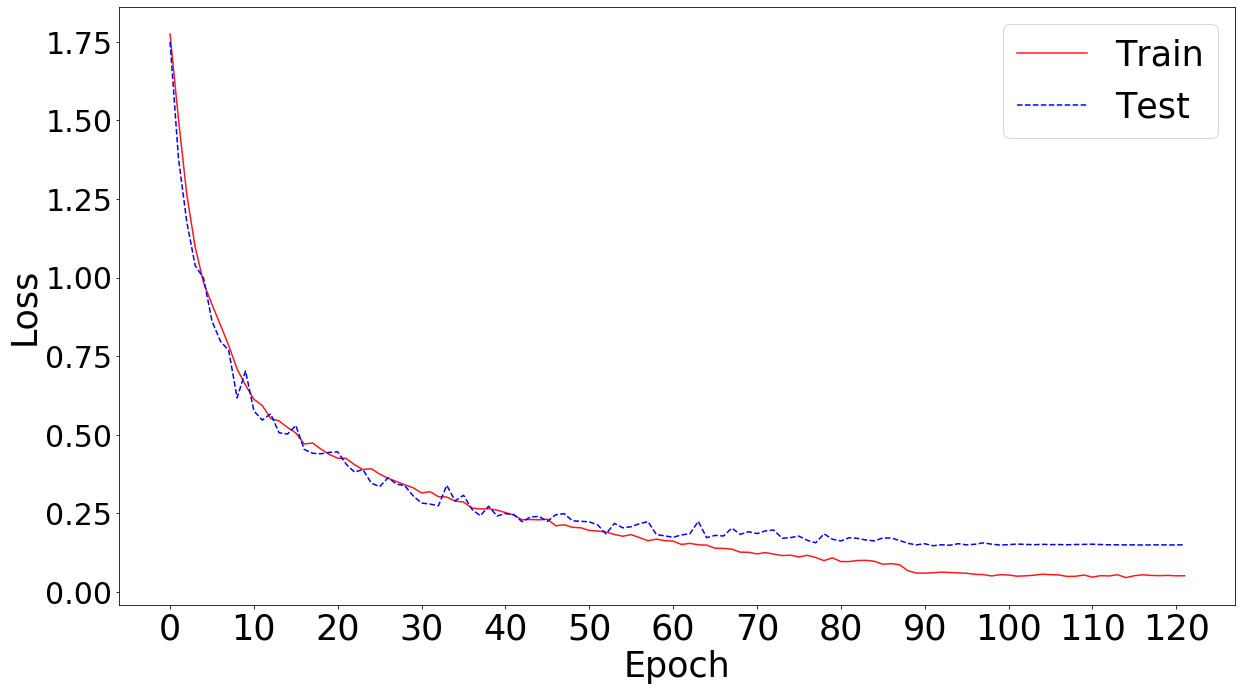

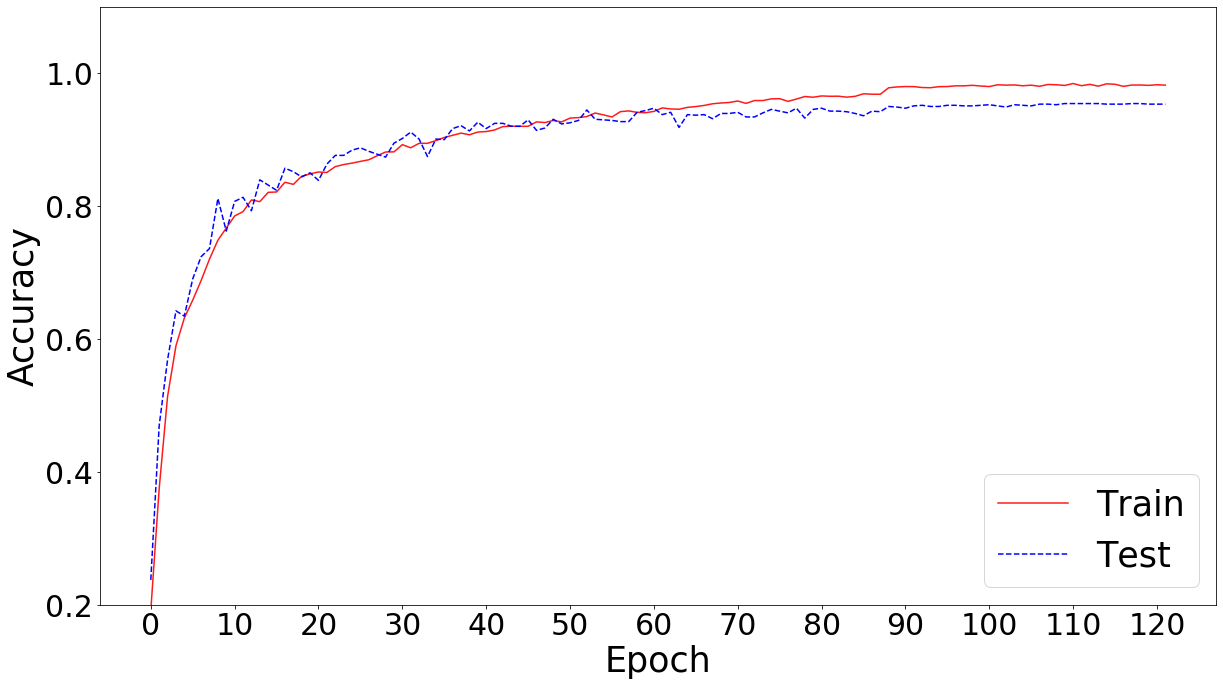

In [14]:
helpers.plot_train_history(history, x_ticks_vertical=True)

In [15]:
# Predict probabilities for test set
y_probs = model.predict(X_test, verbose=0)
yhat_probs = np.argmax(y_probs, axis=1)
y_trues = np.argmax(y_test_encoded, axis=1)

# Add "pred" column
test_meta['pred'] = yhat_probs

C:\Users\user\Anaconda3\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


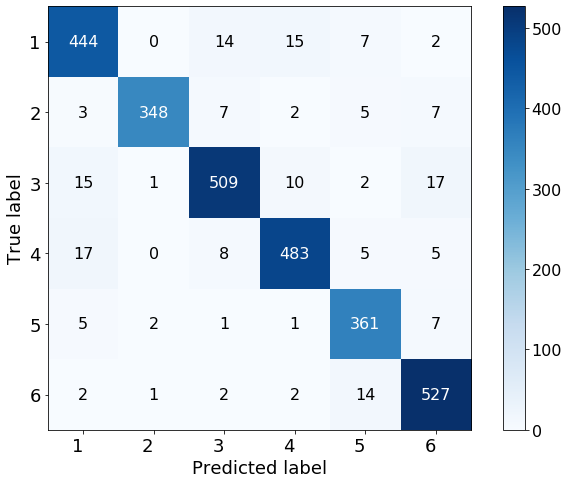

In [48]:
import importlib
importlib.reload(helpers)

# Sets decimal precision (for printing output only)
np.set_printoptions(precision=2)

# Compute confusion matrix data
cm = confusion_matrix(y_trues, yhat_probs)

helpers.plot_confusion_matrix(cm,
                          labels, 
                          normalized=False, 
                          cmap=plt.cm.Blues,
                          size=(10,7))

In [17]:
# Find per-class accuracy from the confusion matrix data
accuracies = helpers.acc_per_class(cm)
result_acc = 'acc_' + file_name
result_path = os.path.join(results_path, result_acc)
print(result_path)
df=pd.DataFrame({
    'CLASS': labels,
    'ACCURACY': accuracies
}).sort_values(by="CLASS", ascending=True)

print(df)

df.to_csv(result_path + '.csv')

D:\KISTI\Project\052020-Traffic-Sound\Yi-Source-Code-3\results\acc_conv5_gap_train_C6_MFCC_40
  CLASS   ACCURACY
0     1  92.116183
1     2  93.548387
2     3  91.877256
3     4  93.243243
4     5  95.755968
5     6  96.167883


In [18]:
# Build classification report
re = classification_report(y_trues, yhat_probs, labels=[0,1,2,3,4,5,6,7,8,9], target_names=labels) 
print(re)
print("Accuracy: {0}".format(accuracy_score(y_trues, yhat_probs)))
print("Precision: {0}".format(precision_score(y_trues, yhat_probs, average='weighted')))
print("Recall: {0}".format(recall_score(y_trues, yhat_probs, average='weighted')))
print("F1-Score: {0}".format(f1_score(y_trues, yhat_probs, average='weighted')))

              precision    recall  f1-score   support

           1       0.91      0.92      0.92       482
           2       0.99      0.94      0.96       372
           3       0.94      0.92      0.93       554
           4       0.94      0.93      0.94       518
           5       0.92      0.96      0.94       377
           6       0.93      0.96      0.95       548

   micro avg       0.94      0.94      0.94      2851
   macro avg       0.56      0.56      0.56      2851
weighted avg       0.94      0.94      0.94      2851

Accuracy: 0.9372150122763943
Precision: 0.9377847362078461
Recall: 0.9372150122763943
F1-Score: 0.9372692560021043


C:\Users\user\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\metrics\classification.py:1870: UserWarning: labels size, 10, does not match size of target_names, 6
  .format(len(labels), len(target_names))
C:\Users\user\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\user\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


## 3. Deep Feature Clasification

CNN with non-softmax classification


### 3.1 Divide feature extraction layers and classification layers


In [19]:
# Layers definitions
from keras import backend as K
for l in range(len(model.layers)):
    print(l, model.layers[l])

0 <keras.layers.convolutional.Conv2D object at 0x000001B363579B48>
1 <keras.layers.advanced_activations.ReLU object at 0x000001B36358F248>
2 <keras.layers.pooling.MaxPooling2D object at 0x000001B363592D88>
3 <keras.layers.core.Dropout object at 0x000001B363594D88>
4 <keras.layers.convolutional.Conv2D object at 0x000001B36359CE88>
5 <keras.layers.advanced_activations.ReLU object at 0x000001B363594E88>
6 <keras.layers.pooling.MaxPooling2D object at 0x000001B3635B1088>
7 <keras.layers.core.Dropout object at 0x000001B3635B1F88>
8 <keras.layers.convolutional.Conv2D object at 0x000001B3635B1108>
9 <keras.layers.advanced_activations.ReLU object at 0x000001B3635C40C8>
10 <keras.layers.pooling.MaxPooling2D object at 0x000001B3635D3F08>
11 <keras.layers.core.Dropout object at 0x000001B3635D5108>
12 <keras.layers.convolutional.Conv2D object at 0x000001B3635D3FC8>
13 <keras.layers.advanced_activations.ReLU object at 0x000001B3635D8D48>
14 <keras.layers.pooling.MaxPooling2D object at 0x000001B3635F

In [20]:
# feature extraction layer
getFeature = K.function([model.layers[0].input, K.learning_phase()],
                        [model.layers[20].output])

In [21]:
# classification layer
getPrediction = K.function([model.layers[21].input, K.learning_phase()],
                           [model.layers[22].output])

### 3.2 Get feature tensors for training and testing data


In [22]:
print(len(X_train))
exTrain = getFeature([X_train[:9500], 0])[0]

11404


In [23]:
exTest = getFeature([X_test, 0])[0]

In [24]:
# output of getFeature function
#exTrain[0]
#exTest[0]

###  3.3 Reshape target to fit to scikit-learn

In [25]:
sklearn_y_train= y_train[:9500].reshape(y_train[:9500].shape[0],)
sklearn_y_test = y_test

In [26]:
print(exTrain.shape, exTest.shape, sklearn_y_train.shape, sklearn_y_test.shape)

(9500, 256) (2851, 256) (9500,) (2851,)


In [27]:
from sklearn.model_selection import GridSearchCV

### 3.4   Scikit-learn Classifiers with feature extracted training data as input

We adopt four algorithms: Support Vector Machine (SVM), Random Forest (RF), L-Neareast Neighbor (KNN), and XGBoots (XGB) 

####  3.4.1 SVM

In [28]:

from sklearn.svm import SVC



start_svm = datetime.now()

parameters = {'kernel':['rbf'], 
              'C':[1, 10, 100, 1000],
              'gamma':[1e-3, 1e-4]}
clf = GridSearchCV(SVC(), parameters)
clf.fit(exTrain, sklearn_y_train)

time_svm = datetime.now() - start_svm
print("Training completed in time of svm: ", time_svm)
file1 = open(os.path.join(models_path, 'time_' + file_name + ".txt"),"a")
file1.write('Time SVM:' +  str(time_svm))
file1.write('\n')
file1.close()

C:\Users\user\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Training completed in time of svm:  0:00:45.189267


In [29]:
svmclf = clf.best_estimator_
svmclf.fit(exTrain, sklearn_y_train)

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

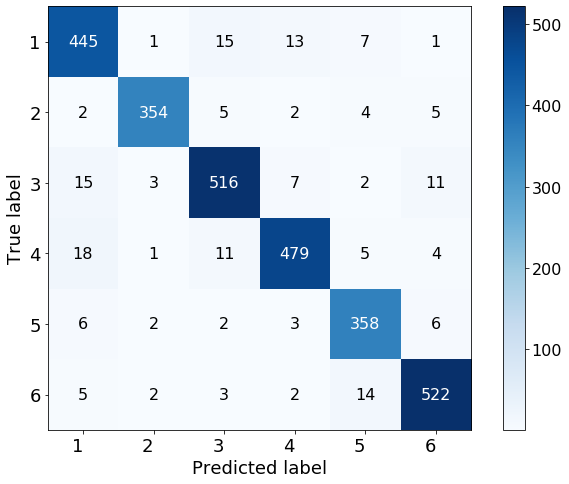

In [50]:

y_testSVM = svmclf.predict(exTest)


# visualize confusion matrix on heat map
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm_svm = confusion_matrix(sklearn_y_test, y_testSVM)

helpers.plot_confusion_matrix(cm_svm,
                          labels, 
                          normalized=False, 
                          cmap=plt.cm.Blues,
                          size=(10,7))




In [31]:
accuracies = helpers.acc_per_class(cm_svm)
result_acc = 'acc_SVM'
result_path = os.path.join(results_path, result_acc)
print(result_path)
df=pd.DataFrame({
    'CLASS': labels,
    'ACCURACY': accuracies
}).sort_values(by="CLASS", ascending=True)

print(df)

df.to_csv(result_path + '.csv')

D:\KISTI\Project\052020-Traffic-Sound\Yi-Source-Code-3\results\acc_SVM
  CLASS   ACCURACY
0     1  92.323651
1     2  95.161290
2     3  93.140794
3     4  92.471042
4     5  94.960212
5     6  95.255474


In [49]:
# Build classification report
re = classification_report(sklearn_y_test, y_testSVM, labels=[1,2,3,4,5,6,7,8,9], target_names=labels) 
print(re)
print("Accuracy: {0}".format(accuracy_score(sklearn_y_test, y_testSVM)))
print("Precision: {0}".format(precision_score(y_trues, yhat_probs, average='weighted')))
print("Recall: {0}".format(recall_score(y_trues, yhat_probs, average='weighted')))
print("F1-Score: {0}".format(f1_score(y_trues, yhat_probs, average='weighted')))

              precision    recall  f1-score   support

           1       0.91      0.92      0.91       482
           2       0.98      0.95      0.96       372
           3       0.93      0.93      0.93       554
           4       0.95      0.92      0.94       518
           5       0.92      0.95      0.93       377
           6       0.95      0.95      0.95       548

   micro avg       0.94      0.94      0.94      2851
   macro avg       0.63      0.63      0.63      2851
weighted avg       0.94      0.94      0.94      2851

Accuracy: 0.9379165205191161
Precision: 0.9377847362078461
Recall: 0.9372150122763943
F1-Score: 0.9372692560021043


#### 3.4.2 Random Forest

In [33]:
from sklearn.ensemble import RandomForestClassifier

start_rf = datetime.now()

parameters = {"max_depth": [3, None],
              "max_features": [1, 3, 10],
              "min_samples_split": [1.0, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"],
              "n_estimators": [10, 20, 50]}
rclf = RandomForestClassifier()
rgclf = GridSearchCV(rclf, param_grid=parameters)
rgclf.fit(exTrain, sklearn_y_train)

time_rf = datetime.now() - start_rf
print("Training completed in time of RF: ", time_rf)
file1 = open(os.path.join(models_path, 'time_' + file_name + ".txt"),"a")
file1.write('Time RF:' +  str(time_rf))
file1.write('\n')
file1.close()

C:\Users\user\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Training completed in time of RF:  0:05:33.080230


In [34]:
rclf = rgclf.best_estimator_
rclf.fit(exTrain, sklearn_y_train)

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='entropy',
                       max_depth=None, max_features=3, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=3,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

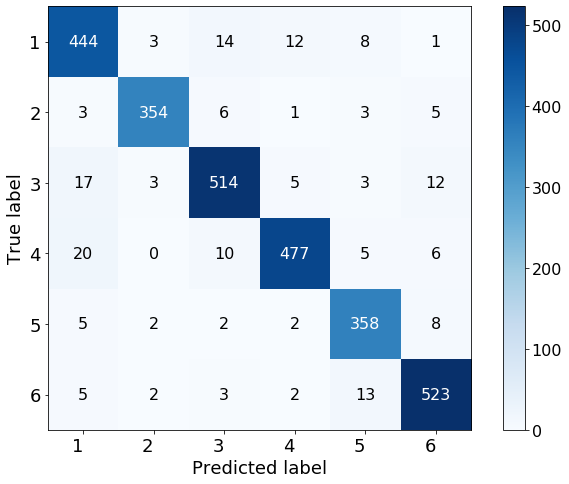

In [51]:
y_testRF = rclf.predict(exTest)

cm_RF = confusion_matrix(sklearn_y_test, y_testRF)


helpers.plot_confusion_matrix(cm_RF,
                          labels, 
                          normalized=False, 
                          cmap=plt.cm.Blues,
                          size=(10,7))



In [36]:
accuracies = helpers.acc_per_class(cm_RF)
result_acc = 'acc_RF'
result_path = os.path.join(results_path, result_acc)
print(result_path)
df=pd.DataFrame({
    'CLASS': labels,
    'ACCURACY': accuracies
}).sort_values(by="CLASS", ascending=True)

print(df)

df.to_csv(result_path + '.csv')

D:\KISTI\Project\052020-Traffic-Sound\Yi-Source-Code-3\results\acc_RF
  CLASS   ACCURACY
0     1  92.116183
1     2  95.161290
2     3  92.779783
3     4  92.084942
4     5  94.960212
5     6  95.437956


In [37]:
# Build classification report
re = classification_report(sklearn_y_test, y_testRF, labels=[1,2,3,4,5,6,7,8,9], target_names=labels) 
print(re)
print("Accuracy: {0}".format(accuracy_score(sklearn_y_test, y_testRF)))

              precision    recall  f1-score   support

           1       0.90      0.92      0.91       482
           2       0.97      0.95      0.96       372
           3       0.94      0.93      0.93       554
           4       0.96      0.92      0.94       518
           5       0.92      0.95      0.93       377
           6       0.94      0.95      0.95       548

   micro avg       0.94      0.94      0.94      2851
   macro avg       0.62      0.63      0.62      2851
weighted avg       0.94      0.94      0.94      2851

Accuracy: 0.9365135040336724


C:\Users\user\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\metrics\classification.py:1870: UserWarning: labels size, 9, does not match size of target_names, 6
  .format(len(labels), len(target_names))
C:\Users\user\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\user\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


#### 3.4.3 K nearest neighbors

In [38]:
from sklearn.neighbors import KNeighborsClassifier

start_Knn = datetime.now()

parameters = {"n_neighbors": [1, 5, 10, 30],
              "weights": ['uniform', 'distance'],
              "metric": ['minkowski','euclidean','manhattan'],
              "algorithm": ['auto', 'ball_tree', 'kd_tree', 'brute']}
kclf = KNeighborsClassifier()
kgclf = GridSearchCV(kclf, param_grid=parameters)
kgclf.fit(exTrain, sklearn_y_train)

time_knn = datetime.now() - start_Knn
print("Training completed in time of KNN: ", time_knn)
file1 = open(os.path.join(models_path, 'time_' + file_name + ".txt"),"a")
file1.write('Time KNN:' +  str(time_knn))
file1.write('\n')
file1.close()

C:\Users\user\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Training completed in time of KNN:  0:10:38.913072


In [39]:
kclf = kgclf.best_estimator_
kclf.fit(exTrain, sklearn_y_train)


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                     weights='distance')

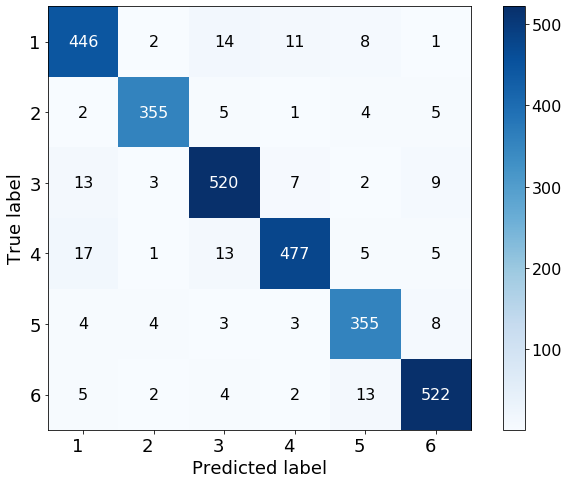

In [52]:
y_testKNN = kclf.predict(exTest)

cm_KNN = confusion_matrix(sklearn_y_test, y_testKNN)


helpers.plot_confusion_matrix(cm_KNN,
                          labels, 
                          normalized=False, 
                          cmap=plt.cm.Blues,
                          size=(10,7))


In [41]:
accuracies = helpers.acc_per_class(cm_KNN)
result_acc = 'acc_KNN'
result_path = os.path.join(results_path, result_acc)
print(result_path)
df=pd.DataFrame({
    'CLASS': labels,
    'ACCURACY': accuracies
}).sort_values(by="CLASS", ascending=True)

print(df)

df.to_csv(result_path + '.csv')

D:\KISTI\Project\052020-Traffic-Sound\Yi-Source-Code-3\results\acc_KNN
  CLASS   ACCURACY
0     1  92.531120
1     2  95.430108
2     3  93.862816
3     4  92.084942
4     5  94.164456
5     6  95.255474


In [42]:
# Build classification report
re = classification_report(sklearn_y_test, y_testKNN, labels=[1,2,3,4,5,6,7,8,9], target_names=labels) 
print(re)
print("Accuracy: {0}".format(accuracy_score(sklearn_y_test, y_testKNN)))

              precision    recall  f1-score   support

           1       0.92      0.93      0.92       482
           2       0.97      0.95      0.96       372
           3       0.93      0.94      0.93       554
           4       0.95      0.92      0.94       518
           5       0.92      0.94      0.93       377
           6       0.95      0.95      0.95       548

   micro avg       0.94      0.94      0.94      2851
   macro avg       0.63      0.63      0.63      2851
weighted avg       0.94      0.94      0.94      2851

Accuracy: 0.938267274640477


C:\Users\user\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\metrics\classification.py:1870: UserWarning: labels size, 9, does not match size of target_names, 6
  .format(len(labels), len(target_names))
C:\Users\user\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\user\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


#### 3.4.4  Xgboost

In [43]:
from xgboost import XGBClassifier

start_xgb = datetime.now()

parameters = {'max_depth':[6], 'eta':[0.3], 'objective':['multi:softprob ']}

xclf = XGBClassifier()
xgclf = GridSearchCV(xclf, param_grid=parameters)
xgclf.fit(exTrain, sklearn_y_train)

time_xgb = datetime.now() - start_xgb
print("Training completed in time of XGB: ", time_xgb)
file1 = open(os.path.join(models_path, 'time_' + file_name + ".txt"),"a")
file1.write('Time XGB:' +  str(time_xgb))
file1.write('\n')
file1.close()

C:\Users\user\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Training completed in time of XGB:  0:00:16.629534


In [44]:
xclf = xgclf.best_estimator_
xclf.fit(exTrain, sklearn_y_train)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=0.3, gamma=0,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

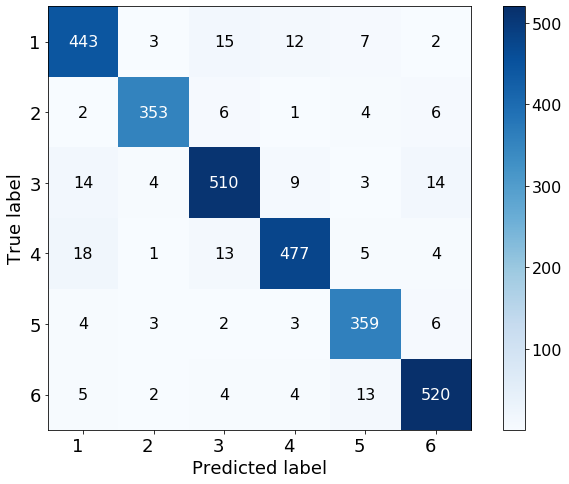

In [53]:
y_testXGB = xclf.predict(exTest)

cm_XGB = confusion_matrix(sklearn_y_test, y_testXGB)

helpers.plot_confusion_matrix(cm_XGB,
                          labels, 
                          normalized=False, 
                          cmap=plt.cm.Blues,
                          size=(10,7))


In [46]:
accuracies = helpers.acc_per_class(cm_XGB)
result_acc = 'acc_XGB'
result_path = os.path.join(results_path, result_acc)
print(result_path)
df=pd.DataFrame({
    'CLASS': labels,
    'ACCURACY': accuracies
}).sort_values(by="CLASS", ascending=True)

print(df)

df.to_csv(result_path + '.csv')

D:\KISTI\Project\052020-Traffic-Sound\Yi-Source-Code-3\results\acc_XGB
  CLASS   ACCURACY
0     1  91.908714
1     2  94.892473
2     3  92.057762
3     4  92.084942
4     5  95.225464
5     6  94.890511


In [47]:
# Build classification report
re = classification_report(sklearn_y_test, y_testXGB, labels=[1,2,3,4,5,6,7,8,9], target_names=labels) 
print(re)
print("Accuracy: {0}".format(accuracy_score(sklearn_y_test, y_testXGB)))
print("Precision: {0}".format(precision_score(y_trues, yhat_probs, average='weighted')))
print("Recall: {0}".format(recall_score(y_trues, yhat_probs, average='weighted')))
print("F1-Score: {0}".format(f1_score(y_trues, yhat_probs, average='weighted')))

              precision    recall  f1-score   support

           1       0.91      0.92      0.92       482
           2       0.96      0.95      0.96       372
           3       0.93      0.92      0.92       554
           4       0.94      0.92      0.93       518
           5       0.92      0.95      0.93       377
           6       0.94      0.95      0.95       548

   micro avg       0.93      0.93      0.93      2851
   macro avg       0.62      0.62      0.62      2851
weighted avg       0.93      0.93      0.93      2851

Accuracy: 0.933707471062785
Precision: 0.9377847362078461
Recall: 0.9372150122763943
F1-Score: 0.9372692560021043


C:\Users\user\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\metrics\classification.py:1870: UserWarning: labels size, 9, does not match size of target_names, 6
  .format(len(labels), len(target_names))
C:\Users\user\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\user\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
